In [1]:
import torch
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
import copy
import sys


# Get the parent directory of the current directory
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from model.diffusion.unet import Unet, UpSample, DownSample, time_embedding
from model.diffusion.diffusion_proc import Diffusion, linear_noise_schedule
from model.diffusion.blocks import ResBlock, AttentionBlock, TimestepBlock, group_norm_layer
from model.diffusion.dataset import CondSeqImageDataset

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-0.5, 63.5, 63.5, -0.5)

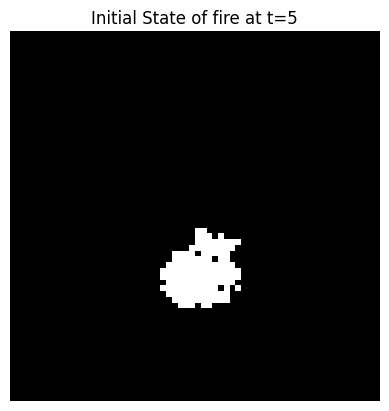

In [2]:
#VOL_PATH = "/vol/bitbucket/ag323"
DATA_DIR =  "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/frame_data_dist" # os.path.join(VOL_PATH, "diss_ag/data/frame_data_dist/")
#MODEL_PATH = os.path.join(VOL_PATH, "diss_ag/results/ckpts/gde_ensemble_model_4_64x64_simData_1000samples.h5") #"C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"
MODEL_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_1000samples.pt"

with open(os.path.join(DATA_DIR, "init_state_0_0.mppy"), 'rb') as f:
    init_state = pickle.load(f)
    init_state = np.where(init_state == 1, 0, init_state)
    init_state = np.where(init_state == 2, 0, init_state)
    init_state = np.where(init_state == 3, 1, init_state)
    init_state = np.where(init_state == 4, 1, init_state)

plt.imshow(init_state, cmap="binary_r")
plt.title("Initial State of fire at t=5")
plt.axis("off")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
diff_model =  Unet(
    in_ch=1,
    cond_ch=1,
    model_ch=96,
    output_ch=1,
    channel_mult=(1, 2, 2),
    attn_res=[],
)
diff_model.load_state_dict(torch.load(MODEL_PATH))
diff_model.to(device)
# diff_model = torch.load(MODEL_PATH)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0): TimestepSeqEmbedding(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSeqEmbedding(
      (0): ResBlock(
        (conv_1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_embedding): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (condition_conv): Sequential(
          (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): SiLU()
        )
        (conv_2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

simulated_data = CondSeqImageDataset(DATA_DIR, transform=transform)

In [5]:
simulated_samples = []
for index in range(4, len(simulated_data), 10):
    _, target = simulated_data[index]
    simulated_samples.append(target.squeeze())

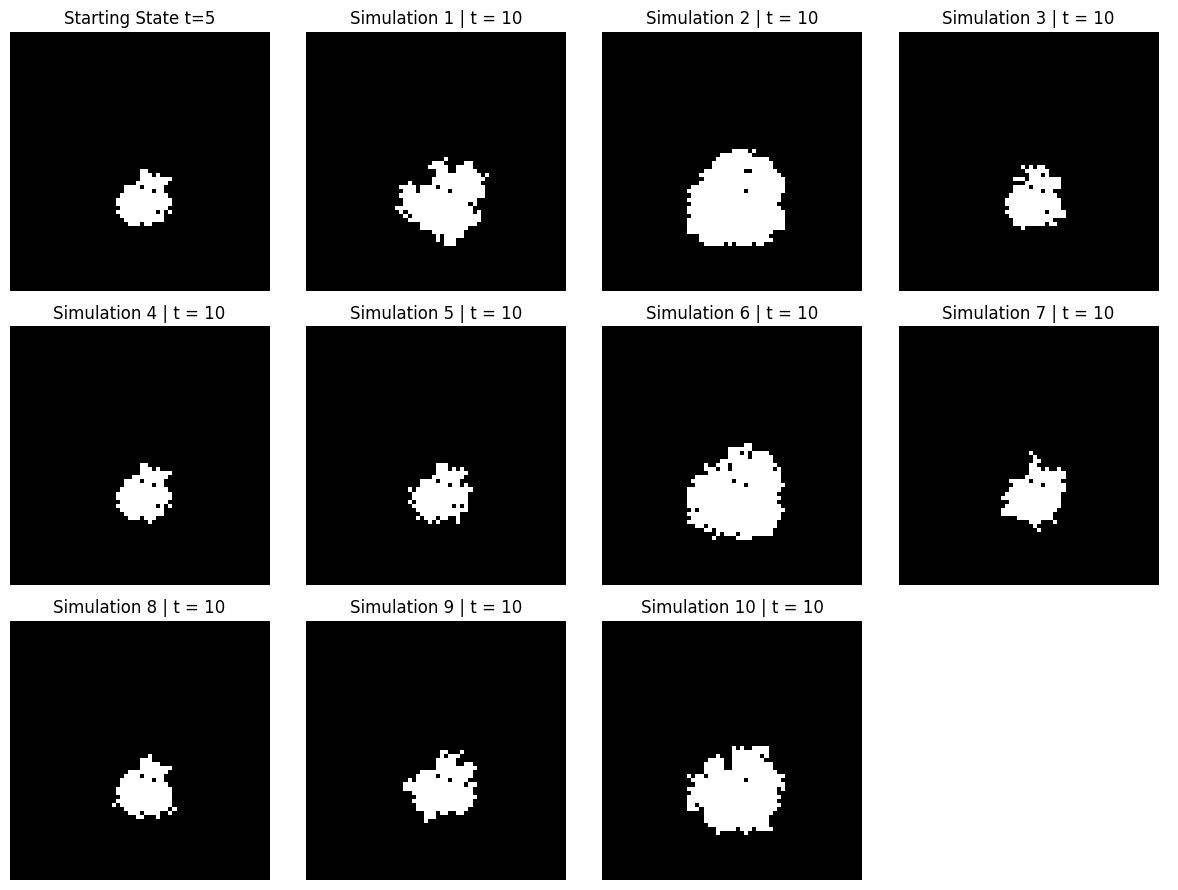

In [6]:
# Create a figure with a grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Plot the starting image
axes[0, 0].imshow(init_state, cmap="binary_r")
axes[0, 0].set_title('Starting State t=5')
axes[0, 0].axis('off')

# Plot the 10 predictions
for i in range(10):
    row = (i + 1) // 4
    col = (i + 1) % 4
    axes[row, col].imshow(simulated_samples[i], cmap="binary_r")
    axes[row, col].set_title(f'Simulation {i + 1} | t = 10')
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(11, 12):
    row = i // 4
    col = i % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

sampling loop time step: 100%|██████████| 500/500 [00:35<00:00, 14.00it/s]


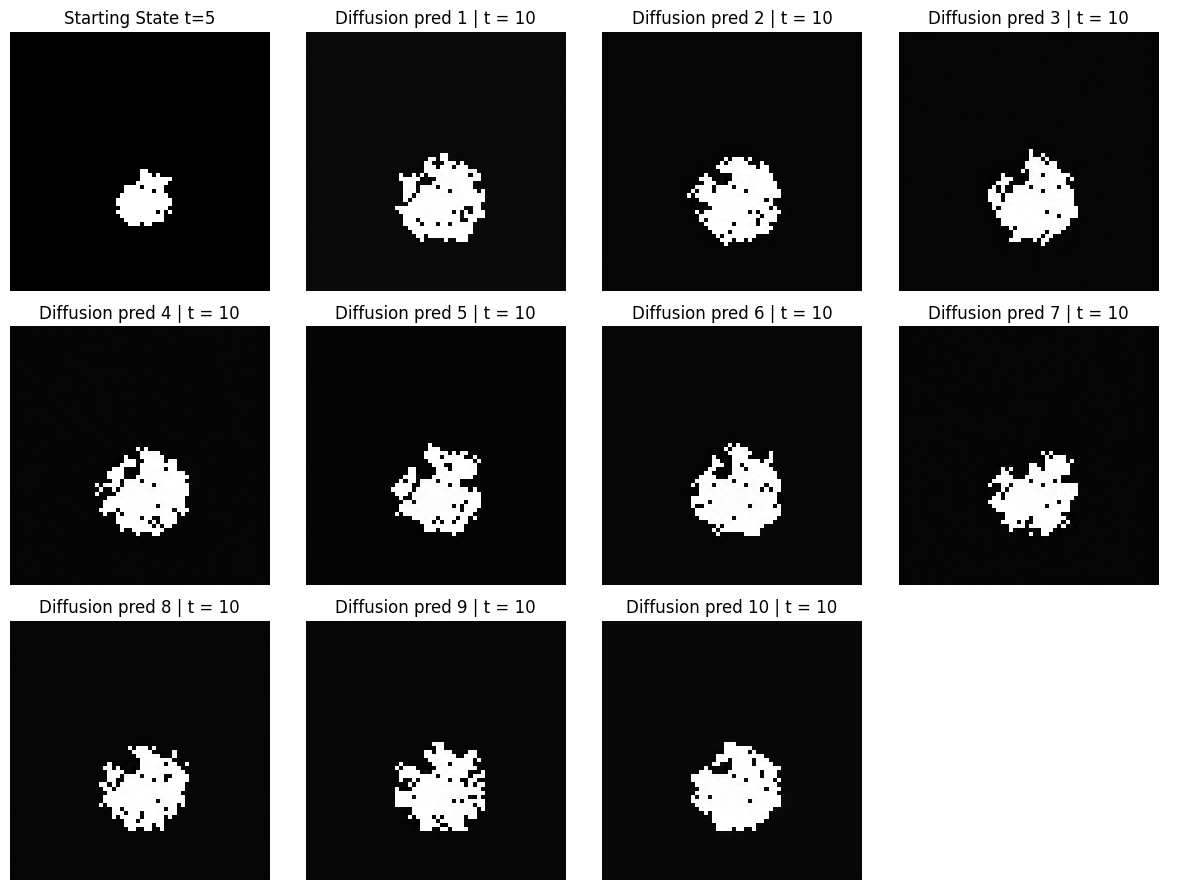

In [9]:
diffusion = Diffusion(timesteps=500, noise_schedule='linear')

input_img_init = transform(init_state).to('cuda').float().unsqueeze(0)
image_size = input_img_init.shape[-1]
channels = input_img_init.shape[1]

generated_outputs = []
for i in range(10):
    generated_images = diffusion.sample(
        model=diff_model,
        image_size=image_size,
        cond_img=input_img_init,
        batch_size=1,  # Set the desired batch size
        channels=channels,
        w=2,
        clip_denoised=True
    )
    generated_outputs.append(generated_images[-1])
    
# Create a figure with a grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Plot the starting image
axes[0, 0].imshow(init_state, cmap="binary_r")
axes[0, 0].set_title('Starting State t=5')
axes[0, 0].axis('off')

# Plot the 10 predictions
for i in range(10):
    row = (i + 1) // 4
    col = (i + 1) % 4
    img = generated_outputs[i].squeeze().squeeze()
    axes[row, col].imshow(img, cmap="binary_r")
    axes[row, col].set_title(f'Diffusion pred {i + 1} | t = 10')
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(11, 12):
    row = i // 4
    col = i % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


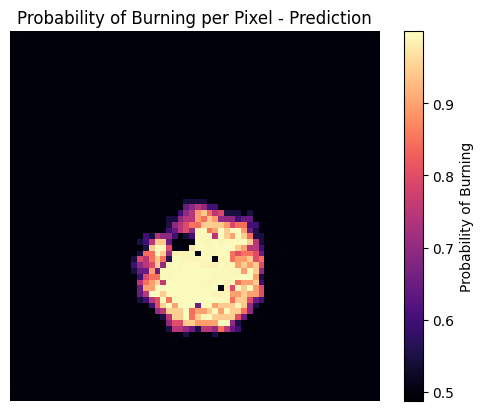

In [14]:
predictions = []
for image in generated_outputs:
    img = image.squeeze().squeeze()
    predictions.append(img)

normalized_predictions = [(prediction + 1) / 2 for prediction in predictions]  

def generate_burn_probability(image_array, title='Probability of Burning per Pixel'):
    predictions_array = np.stack(image_array, axis=0) 
    burn_probabilities = np.mean(predictions_array, axis=0)  # Shape: (64, 64)

    plt.imshow(burn_probabilities, cmap='magma', interpolation='nearest')
    plt.colorbar(label='Probability of Burning')
    plt.title(title)
    plt.axis("off")
    plt.show()
    
generate_burn_probability(normalized_predictions, title="Probability of Burning per Pixel - Prediction")

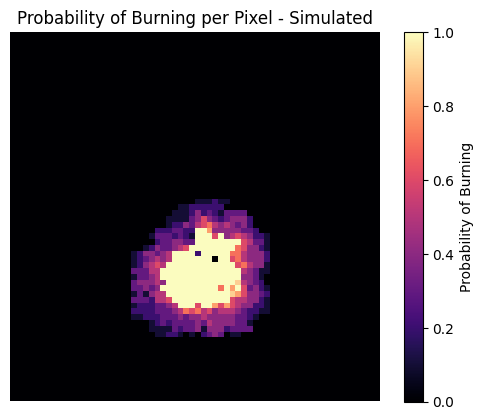

In [15]:
generate_burn_probability(simulated_samples, title="Probability of Burning per Pixel - Simulated")

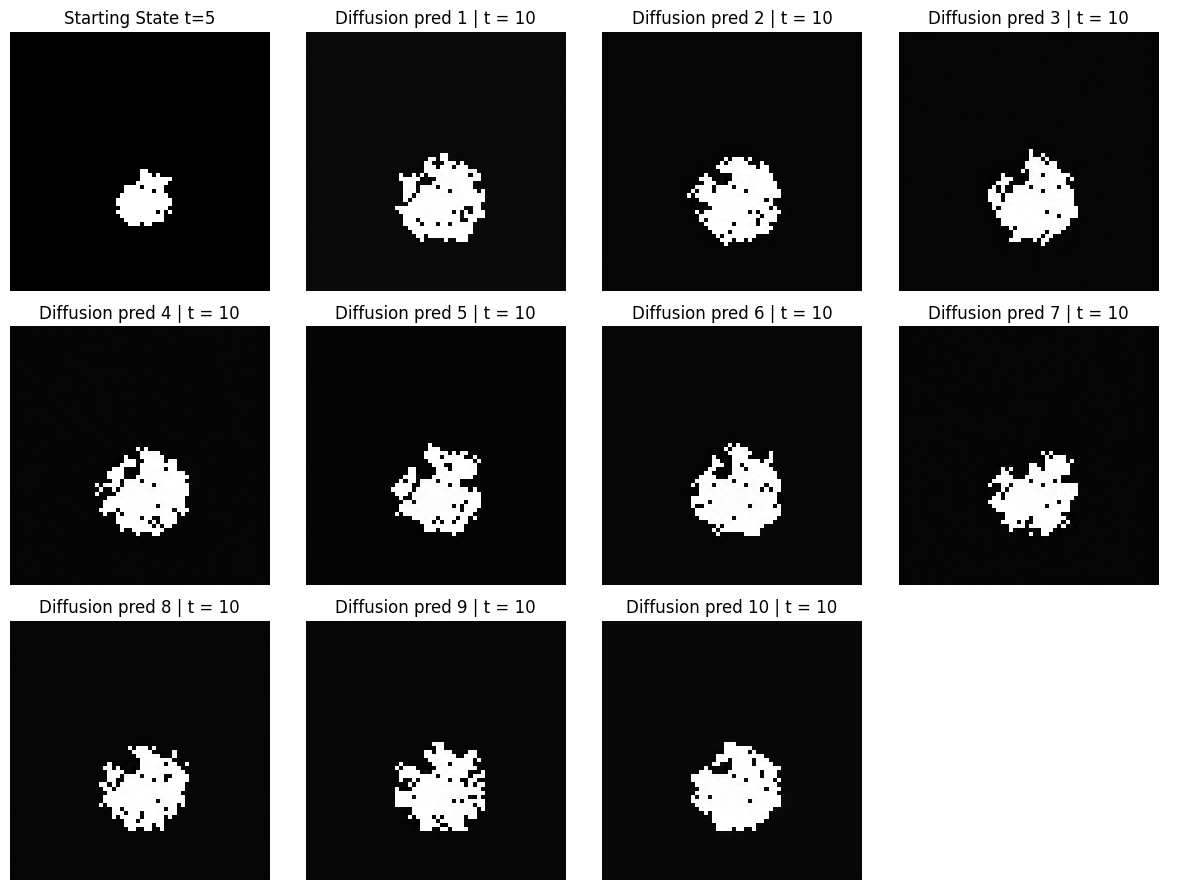

In [12]:
# Create a figure with a grid layout
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Plot the starting image
axes[0, 0].imshow(init_state, cmap="binary_r")
axes[0, 0].set_title('Starting State t=5')
axes[0, 0].axis('off')

# Plot the 10 predictions
for i in range(10):
    row = (i + 1) // 4
    col = (i + 1) % 4
    img = generated_outputs[i].squeeze().squeeze()
    axes[row, col].imshow(img, cmap="binary_r")
    axes[row, col].set_title(f'Diffusion pred {i + 1} | t = 10')
    axes[row, col].axis('off')

# Hide any unused subplots
for i in range(11, 12):
    row = i // 4
    col = i % 4
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()